# Machine Learning Nanodegree

### Capstone Project
---

## Stock Price Prediction


---

### Read in the Data


In [1]:
%autosave 60
# import all libraries
import io
import os
import time, requests
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

Autosaving every 60 seconds


In [2]:
!pip -q install -r requirements.txt --upgrade --no-cache-dir

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [4]:
import yfinance as yf

# def get_epoch_time(date):
#     ''' Get the epoch time for a particular date
#         param | date: Date in the format YYYY-MM-DD
#     '''
#     os.environ['TZ']='EST+5ETD'
#     date_time = date + ' 00:00:00'
#     pattern = '%Y-%m-%d %H:%M:%S'
    
#     epoch = int(time.mktime(time.strptime(date_time, pattern)))
#     return epoch

def get_historical_data(symbol,start_date,end_date, data_dir):
    ''' Daily quotes from Google. Date format='yyyy-mm-dd' '''
    symbol = symbol.upper()
    df = yf.download('{0}'.format(symbol), start=start_date, end=end_date)
    df.to_csv(data_dir+'{0}.csv'.format(symbol), index = True, header=False)
    col_names = ['Date','Open','High','Low','Close','Adj_Close','Volume']
    stocks = pd.read_csv('data/{0}.csv'.format(symbol), header=0, names=col_names)
    
    dataFile = pd.DataFrame(stocks)
    return dataFile
    
#     col_names = ['Date','Open','High','Low','Close','Volume']
#     stocks = pd.read_csv(url_string, header=0, names=col_names) 
    
#     df = pd.DataFrame(stocks)
#     return df

In [5]:
source_dir = '/home/ec2-user/SageMaker/ML_Stock_Price_Prediction'
os.chdir(source_dir)

data_dir = source_dir + '/data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

processed_data_dir = source_dir +'/data/processedData'
if not os.path.exists(processed_data_dir):
    os.makedirs(processed_data_dir) 

symbol = 'GOOGL'
start  = '2009-11-01'
end    = '2019-11-01'

data = get_historical_data(symbol, start, end, data_dir) # from January 1, 2005 to June 30, 2017

[*********************100%***********************]  1 of 1 completed


In [6]:
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2009-11-03,265.270264,269.019012,264.414429,268.913910,268.913910,4755600
1,2009-11-04,270.670685,273.023010,268.478485,270.435425,270.435425,4660700
2,2009-11-05,272.017029,275.160156,271.601593,274.599609,274.599609,3691700
3,2009-11-06,274.134125,276.166168,273.023010,275.825836,275.825836,3649700
4,2009-11-09,278.002991,281.571564,277.392395,281.536530,281.536530,5294500


In [7]:
data.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,635.397300,640.689145,629.668080,635.334439,635.334439,3.427869e+06
std,320.135523,322.995625,317.249482,320.265958,320.265958,2.672654e+06
min,219.374374,221.361359,217.032028,218.253250,218.253250,5.206000e+05
25%,311.961975,314.191681,310.307800,312.367371,312.367371,1.583525e+06
50%,561.025024,565.725006,556.744995,561.229980,561.229980,2.561600e+06
75%,924.400009,934.392487,919.444992,924.935013,924.935013,4.489575e+06
max,1289.119995,1299.239990,1272.310059,1296.199951,1296.199951,2.961990e+07


In [8]:
from src import viz_functions as viz, processData as ppd 


In [9]:
stocks = ppd.remove_data(data)

#Print the dataframe head and tail
print(stocks.head())
print("---")
print(stocks.tail())

   Item        Open       Close   Volume
0     0  265.270264  268.913910  4755600
1     1  270.670685  270.435425  4660700
2     2  272.017029  274.599609  3691700
3     3  274.134125  275.825836  3649700
4     4  278.002991  281.536530  5294500
---
      Item         Open        Close   Volume
2511  2511  1252.000000  1264.300049  1355200
2512  2512  1275.000000  1288.979980  3271400
2513  2513  1276.000000  1260.660034  2632700
2514  2514  1255.150024  1260.699951  1460200
2515  2515  1260.000000  1258.800049  1595000


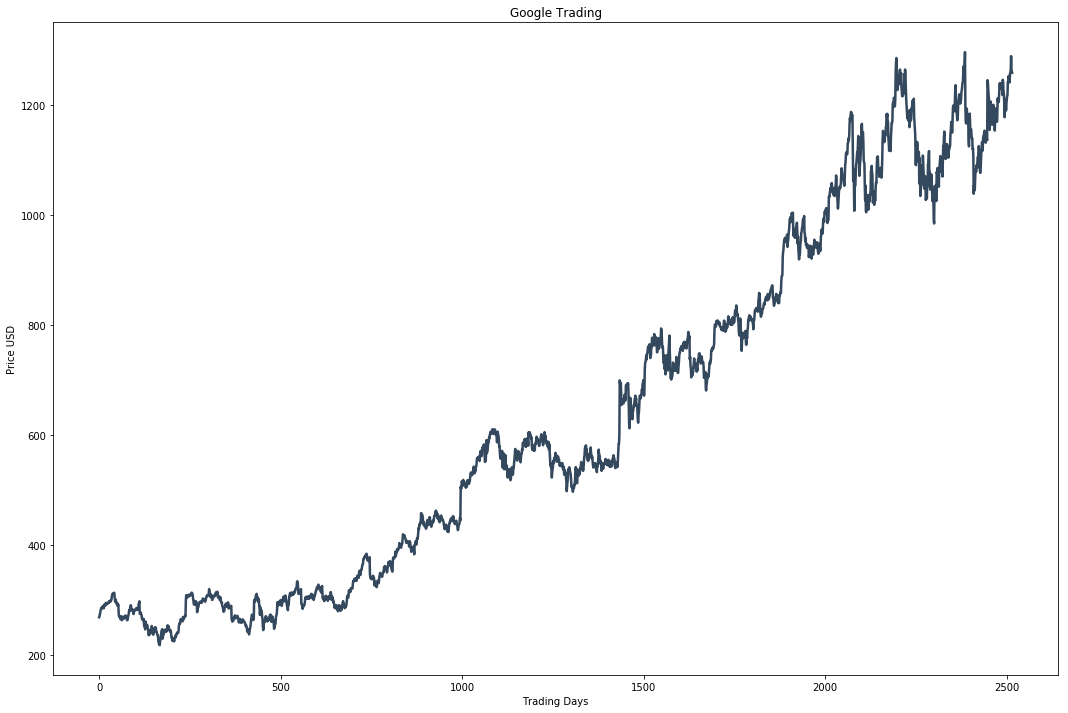

In [10]:
viz.plot_basic(stocks)

In [11]:
stocks = ppd.normalise_data(stocks)
print(stocks.head())

   Item      Open     Close    Volume
0     0  0.042904  0.046997  0.145536
1     1  0.047952  0.048409  0.142275
2     2  0.049210  0.052272  0.108975
3     3  0.051190  0.053409  0.107532
4     4  0.054806  0.058707  0.164055


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


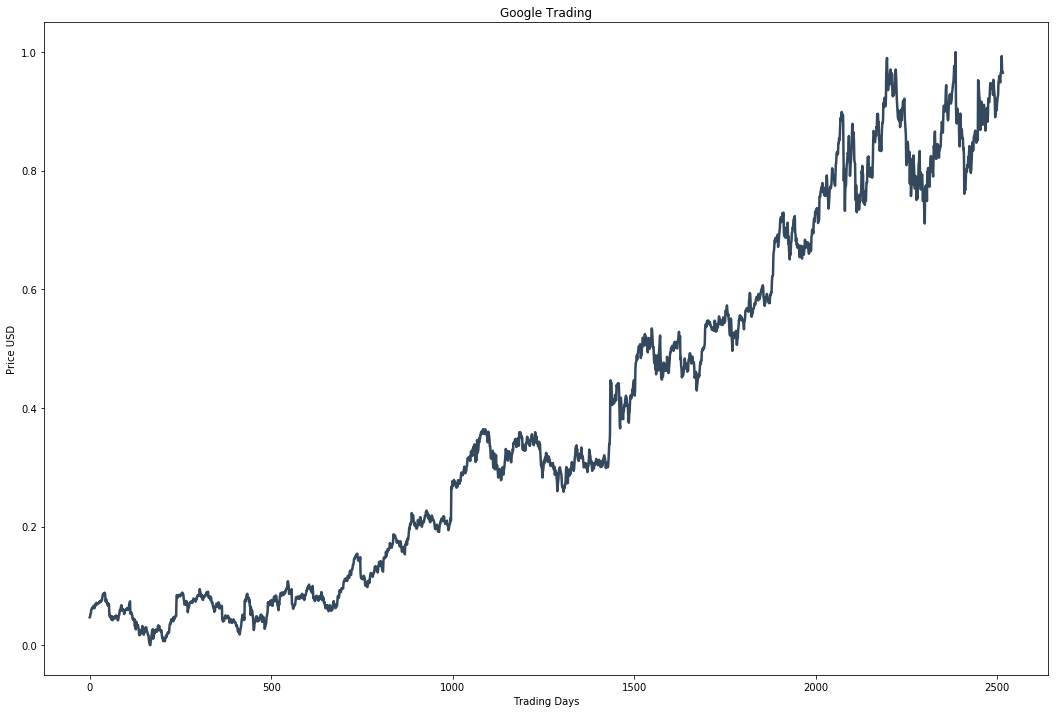

In [12]:
viz.plot_basic(stocks)

In [13]:
if not os.path.exists(processed_data_dir): # Make sure that the folder exists
    os.makedirs(processed_data_dir)

In [14]:
stocks.to_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol) ,index= False, header=True)

## Linear Regression 

In [15]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'stockPrices'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='regressor',
                       loss='squared_loss',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)

In [ ]:
stocks = pd.read_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol))
display(stocks.head())

In [ ]:
train_fraction = 0.8
X_train, X_test, y_train, y_test = ppd.train_test_split(stocks, train_fraction)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

In [ ]:
# convert features/labels to numpy in float32 format
train_x_np = X_train.astype('float32')
train_y_np = y_train.astype('float32')

print("y_train", train_y_np.shape)

# create RecordSet
formatted_train_data = linear.record_set(train_x_np , labels=train_y_np)

In [ ]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

In [ ]:
# convert features/labels to numpy
test_x_np = X_test.astype('float32')
test_y_np = y_test.astype('float32')

In [ ]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

### Evaluate Model

In [ ]:
# from sagemaker.predictor import csv_serializer, json_deserializer

result = linear_predictor.predict(test_x_np[0])
print (result)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    viz.plot_prediction(test_labels, test_preds)
    
#     # calculate true positives, false positives, true negatives, false negatives
#     tp = np.logical_and(test_labels, test_preds).sum()
#     fp = np.logical_and(1-test_labels, test_preds).sum()
#     tn = np.logical_and(1-test_labels, 1-test_preds).sum()
#     fn = np.logical_and(test_labels, 1-test_preds).sum()
    
#     # calculate binary classification metrics
#     recall = tp / (tp + fn)
#     precision = tp / (tp + fp)
#     accuracy = (tp + tn) / (tp + fp + tn + fn)

    #calculate the score based on mean squared error
    score = mean_squared_error(test_preds, test_labels)
    
    # printing a table of metrics
    if verbose:
#         print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
#         print("\n{:<11} {:.3f}".format('Recall:', recall))
#         print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))
        print()
        
    return {'Predictions': test_preds, 'Score': score}

In [ ]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
predictions, metrics = evaluate(linear_predictor, 
                   test_x_np, 
                   test_y_np, 
                   verbose=True) # verbose means we'll print out the metrics

In [16]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [ ]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

## XGBoost

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

In [18]:
stocks = pd.read_csv(processed_data_dir + '/{0}_processed.csv'.format(symbol))
display(stocks.head())

display(stocks.tail())

,Item,Open,Close,Volume
0,0,0.042904,0.046997,0.145536
1,1,0.047952,0.048409,0.142275
2,2,0.049210,0.052272,0.108975
3,3,0.051190,0.053409,0.107532
4,4,0.054806,0.058707,0.164055


,Item,Open,Close,Volume
2511,2511,0.965300,0.970407,0.028681
2512,2512,0.986801,0.993302,0.094531
2513,2513,0.987735,0.967030,0.072583
2514,2514,0.968245,0.967067,0.032289
2515,2515,0.972779,0.965304,0.036922


In [19]:
train_fraction = 0.8
val_fraction = 0.2

X_train, X_val, X_test, y_train, y_val, y_test = ppd.train_test_split(stocks, 
                                                                      train_fraction, 
                                                                      val_frac=val_fraction)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_validation", X_val.shape)
print("y_validation", y_val.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (1610, 3)
y_train (1610,)
x_validation (402, 3)
y_validation (402,)
x_test (504, 3)
y_test (504,)


/home/ec2-user/SageMaker/ML_Stock_Price_Prediction/src/processData.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  stock_matrix = stocks.as_matrix()


In [20]:
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
X_test.to_csv(os.path.join(processed_data_dir, 'XGB_features_test.csv'), header=False, index=False)
y_test.to_csv(os.path.join(processed_data_dir, 'XGB_labels_test.csv'), header=False, index=False)

pd.concat([pd.DataFrame(y_val), pd.DataFrame(X_val)], axis=1).to_csv(os.path.join(processed_data_dir, 'XGB_validation.csv'), header=False, index=False)
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(processed_data_dir, 'XGB_train.csv'), header=False, index=False)

In [21]:
prefix = 'stockPrices-xgboost'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

test_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_features_test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(processed_data_dir, 'XGB_train.csv'), key_prefix=prefix)

In [22]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container,     # The name of the training container
                                    role = role,             # The IAM role to use (our current role in this case)
                                    train_instance_count=1,  # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path= output_path,  # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


In [24]:
xgb.set_hyperparameters(base_score=0.5, 
                        booster='gbtree',
                        max_depth=3,
                        eta=0.1,
                        gamma=0,
                        alpha=0,
                        min_child_weight=13,
                        subsample=1.0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=1000)

In [25]:
%%time
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-11-21 16:26:28 Starting - Starting the training job...
2019-11-21 16:26:29 Starting - Launching requested ML instances...
2019-11-21 16:27:24 Starting - Preparing the instances for training......
2019-11-21 16:28:27 Downloading - Downloading input data......
2019-11-21 16:29:23 Training - Training image download completed. Training in progress.
2019-11-21 16:29:23 Uploading - Uploading generated training modelArguments: train
[2019-11-21:16:29:18:INFO] Running standalone xgboost training.
[2019-11-21:16:29:18:INFO] File size need to be processed in the node: 0.13mb. Available memory size in the node: 8600.49mb
[2019-11-21:16:29:18:INFO] Determined delimiter of CSV input is ','
[16:29:18] S3DistributionType set as FullyReplicated
[16:29:18] 1610x3 matrix with 4830 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-11-21:16:29:18:INFO] Determined delimiter of CSV input is ','
[16:29:18] S3DistributionType set as FullyReplicated
[16:29:18] 402x3 


2019-11-21 16:29:30 Completed - Training job completed
Training seconds: 63
Billable seconds: 63
CPU times: user 466 ms, sys: 27.3 ms, total: 493 ms
Wall time: 3min 41s


In [ ]:
# xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
# xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [ ]:
# xgb_transformer.wait()

In [ ]:
# !aws s3 cp --recursive $xgb_transformer.output_path $processed_data_dir

In [ ]:
# Y_pred = pd.read_csv(os.path.join(processed_data_dir, 'XGB_features_test.csv.out'), header=None)

In [ ]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

predictions = xgb_predictor.predict(X_test)
# predictions = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
predictions = np.fromstring(predictions, sep=',')
predictions = pd.DataFrame(predictions)

In [ ]:
viz.plot_prediction(y_test, Y_pred)
# plt.scatter(y_test, Y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

score = mean_squared_error(y_test, predictions)
print("{:<11} {:.8f} MSE ({:.8f} RMSE)".format('Score:', score, math.sqrt(score)))

In [ ]:
# delete the predictor endpoint 
delete_endpoint(xgb_predictor)

In [ ]:
# First we will remove all of the files contained in the data_dir directory
# And then we delete the directory itself
%rm -rf $processed_data_dir/*
%rm -rf $processed_data_dir

%rm -rf $data_dir/*
%rm -rf $data_dir